# BOW and TFIDF on reddit data

Now we will analyze text data of reddit.com/r/news 

The data was downloaded 

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltk
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer, word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\magdalena.kalbarczyk\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\magdalena.kalbarczyk\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!


#### There were many titles which were not in english. We had to use lang_detect package in order to select only english titles.

In [185]:
news_reddit = pd.read_csv('../data/news_lang.csv', sep=";")

In [186]:
news_reddit.shape

(783704, 5)

In [187]:
news_reddit = news_reddit[news_reddit["lang"]=="en"]

In [188]:
news_reddit.shape

(582523, 5)

In [189]:
news_reddit.columns

Index(['title', 'score', 'num_comments', 'created_utc', 'lang'], dtype='object')

In [190]:
news_reddit.head()

,title,score,num_comments,created_utc,lang
0,Texas teen tackled by cop at pool party files ...,0,0,1483629018,en
1,John Kerry In Leaked Audio Admits U.S. Allowed...,0,0,1483872751,en
2,2017 American Liberty 225th Anniversary Gold C...,0,0,1484327875,en
3,Repair broken glass with Sensible cost | Call ...,0,0,1484798494,en
4,Today is the last day to register for Obamacare,0,0,1485872414,en


In [191]:
news_reddit.groupby('score').\
    apply(lambda x: len(x)).\
    sort_values().nlargest(10)

score
1    498843
0     12373
2     10387
3      4936
4      2893
5      2776
6      2394
7      2014
8      1702
9      1465
dtype: int64

In [192]:
news_reddit.groupby('score').\
    apply(lambda x: len(x)).\
    sort_values().nsmallest(10)

score
2559    1
5285    1
5304    1
5306    1
5314    1
5324    1
5325    1
5350    1
5372    1
5374    1
dtype: int64

In [193]:
news_reddit[news_reddit['score']<=1].shape

(511216, 5)

In [194]:
news_reddit[news_reddit['score']>1].shape

(71307, 5)

In [195]:
ones = news_reddit[news_reddit['score']==1].sample(n=(news_reddit[news_reddit['score']>1].shape[0]-news_reddit[news_reddit['score']==0].shape[0]))
zeros = news_reddit[news_reddit['score']==0]
rest = news_reddit[news_reddit['score']>1]

news_reddit = pd.concat([ones, zeros, rest])
news_reddit.sample(frac=1)
news_reddit.head()

,title,score,num_comments,created_utc,lang
381022,Tax to GDP ratio: Personal income tax comes to...,1,0,1513867092,en
47845,Supreme Court rules Theresa May cannot trigger...,1,0,1485257753,en
537638,"OJ Simpson free on parole, set to be released ...",1,0,1500577298,en
543174,The Perfect Pouch for Everyone's Eyes,1,0,1500893271,en
649552,Glass Company in Dubai,1,1,1484228434,en


In [196]:
news_reddit['title'][0]

'Texas teen tackled by cop at pool party files lawsuit'

## What were reddit posts about?
* Data preprocesing
* WordCloud

In [197]:
stop = set(stopwords.words('english'))

In [198]:
news_reddit.head()

,title,score,num_comments,created_utc,lang
381022,Tax to GDP ratio: Personal income tax comes to...,1,0,1513867092,en
47845,Supreme Court rules Theresa May cannot trigger...,1,0,1485257753,en
537638,"OJ Simpson free on parole, set to be released ...",1,0,1500577298,en
543174,The Perfect Pouch for Everyone's Eyes,1,0,1500893271,en
649552,Glass Company in Dubai,1,1,1484228434,en


#### There were some difficulties when tokenizing data. NLTK offers many different tokenizers
* Tokenizer: word_tokenize - problem with words like it's, isn't
* Tokenizer: TweetTokenizer - problem with words like "U.S.A."

#### How to deal with the problem?

In [199]:
tokenizer1 = word_tokenize("He isn't in the U.S.A. today")
tokenizer1

['He', 'is', "n't", 'in', 'the', 'U.S.A.', 'today']

In [200]:
tokenizer2 = TweetTokenizer()
tokenizer2. tokenize("He isn't in the U.S.A. today")

['He', "isn't", 'in', 'the', 'U', '.', 'S', '.', 'A', '.', 'today']

#### Finally we decided to do it in our own way! We delete everything after apostrophe and than define RegexpTokenizer.

In [201]:
news_reddit["title"] = news_reddit['title'].apply(lambda x:  re.sub(r"\'.+?", '', x))
pattern = r'[\d.,]+|[A-Z][.A-Z]+\b\.*|\w+|\S'
tokenizer = RegexpTokenizer(pattern)
news_reddit["tokenized_titles"] = news_reddit['title'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [202]:
news_reddit.iloc[0:15,:]

,title,score,num_comments,created_utc,lang,tokenized_titles
381022,Tax to GDP ratio: Personal income tax comes to...,1,0,1513867092,en,"[tax, to, gdp, ratio, :, personal, income, tax..."
47845,Supreme Court rules Theresa May cannot trigger...,1,0,1485257753,en,"[supreme, court, rules, theresa, may, cannot, ..."
537638,"OJ Simpson free on parole, set to be released ...",1,0,1500577298,en,"[oj, simpson, free, on, parole, ,, set, to, be..."
543174,The Perfect Pouch for Everyone Eyes,1,0,1500893271,en,"[the, perfect, pouch, for, everyone, eyes]"
649552,Glass Company in Dubai,1,1,1484228434,en,"[glass, company, in, dubai]"
652639,5 Types of Sex Discrimination You Should Know Now,1,1,1483507871,en,"[5, types, of, sex, discrimination, you, shoul..."
122310,The story of married twins trying for IVF was ...,1,0,1492342084,en,"[the, story, of, married, twins, trying, for, ..."
246308,Bellacures Launches Cannabis anna-CureManicure...,1,0,1509392416,en,"[bellacures, launches, cannabis, anna, -, cure..."
575254,At least one killed as white nationalist rally...,1,0,1502566725,en,"[at, least, one, killed, as, white, nationalis..."
466219,Test and Measurement Companies in India,1,0,1497514205,en,"[test, and, measurement, companies, in, india]"


In [203]:
news_reddit['tokenized_titles'] = news_reddit['tokenized_titles'].apply(lambda x: [item for item in x if item not in stop])
news_reddit.head()

,title,score,num_comments,created_utc,lang,tokenized_titles
381022,Tax to GDP ratio: Personal income tax comes to...,1,0,1513867092,en,"[tax, gdp, ratio, :, personal, income, tax, co..."
47845,Supreme Court rules Theresa May cannot trigger...,1,0,1485257753,en,"[supreme, court, rules, theresa, may, cannot, ..."
537638,"OJ Simpson free on parole, set to be released ...",1,0,1500577298,en,"[oj, simpson, free, parole, ,, set, released, ..."
543174,The Perfect Pouch for Everyone Eyes,1,0,1500893271,en,"[perfect, pouch, everyone, eyes]"
649552,Glass Company in Dubai,1,1,1484228434,en,"[glass, company, dubai]"


## Lemmas

In [204]:
lemmatizer = WordNetLemmatizer()
news_reddit['lemmatized_titles'] = news_reddit['tokenized_titles'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])

In [205]:
news_reddit.iloc[1:50,:]

,title,score,num_comments,created_utc,lang,tokenized_titles,lemmatized_titles
47845,Supreme Court rules Theresa May cannot trigger...,1,0,1485257753,en,"[supreme, court, rules, theresa, may, cannot, ...","[supreme, court, rule, theresa, may, cannot, t..."
537638,"OJ Simpson free on parole, set to be released ...",1,0,1500577298,en,"[oj, simpson, free, parole, ,, set, released, ...","[oj, simpson, free, parole, ,, set, released, ..."
543174,The Perfect Pouch for Everyone Eyes,1,0,1500893271,en,"[perfect, pouch, everyone, eyes]","[perfect, pouch, everyone, eye]"
649552,Glass Company in Dubai,1,1,1484228434,en,"[glass, company, dubai]","[glass, company, dubai]"
652639,5 Types of Sex Discrimination You Should Know Now,1,1,1483507871,en,"[5, types, sex, discrimination, know]","[5, type, sex, discrimination, know]"
122310,The story of married twins trying for IVF was ...,1,0,1492342084,en,"[story, married, twins, trying, ivf, hoax]","[story, married, twin, trying, ivf, hoax]"
246308,Bellacures Launches Cannabis anna-CureManicure...,1,0,1509392416,en,"[bellacures, launches, cannabis, anna, -, cure...","[bellacures, launch, cannabis, anna, -, curema..."
575254,At least one killed as white nationalist rally...,1,0,1502566725,en,"[least, one, killed, white, nationalist, rally...","[least, one, killed, white, nationalist, rally..."
466219,Test and Measurement Companies in India,1,0,1497514205,en,"[test, measurement, companies, india]","[test, measurement, company, india]"
123591,7 MOST COMMON HOME LOAN PROBLEMS FACED BY BORR...,1,0,1490012393,en,"[7, common, home, loan, problems, faced, borro...","[7, common, home, loan, problem, faced, borrow..."


In [206]:
news_reddit['lemmatized_titles'] = news_reddit['lemmatized_titles'].apply(lambda x:  [''.join(c for c in s if c not in string.punctuation) for s in x])
news_reddit['lemmatized_titles'] = news_reddit['lemmatized_titles'].apply(lambda x:  [s for s in x if s])

In [207]:
news_reddit.iloc[1:20,:]

,title,score,num_comments,created_utc,lang,tokenized_titles,lemmatized_titles
47845,Supreme Court rules Theresa May cannot trigger...,1,0,1485257753,en,"[supreme, court, rules, theresa, may, cannot, ...","[supreme, court, rule, theresa, may, cannot, t..."
537638,"OJ Simpson free on parole, set to be released ...",1,0,1500577298,en,"[oj, simpson, free, parole, ,, set, released, ...","[oj, simpson, free, parole, set, released, oct..."
543174,The Perfect Pouch for Everyone Eyes,1,0,1500893271,en,"[perfect, pouch, everyone, eyes]","[perfect, pouch, everyone, eye]"
649552,Glass Company in Dubai,1,1,1484228434,en,"[glass, company, dubai]","[glass, company, dubai]"
652639,5 Types of Sex Discrimination You Should Know Now,1,1,1483507871,en,"[5, types, sex, discrimination, know]","[5, type, sex, discrimination, know]"
122310,The story of married twins trying for IVF was ...,1,0,1492342084,en,"[story, married, twins, trying, ivf, hoax]","[story, married, twin, trying, ivf, hoax]"
246308,Bellacures Launches Cannabis anna-CureManicure...,1,0,1509392416,en,"[bellacures, launches, cannabis, anna, -, cure...","[bellacures, launch, cannabis, anna, curemanic..."
575254,At least one killed as white nationalist rally...,1,0,1502566725,en,"[least, one, killed, white, nationalist, rally...","[least, one, killed, white, nationalist, rally..."
466219,Test and Measurement Companies in India,1,0,1497514205,en,"[test, measurement, companies, india]","[test, measurement, company, india]"
123591,7 MOST COMMON HOME LOAN PROBLEMS FACED BY BORR...,1,0,1490012393,en,"[7, common, home, loan, problems, faced, borro...","[7, common, home, loan, problem, faced, borrow..."


## WordCloud

In [208]:
list_of_words = [y for x in news_reddit['lemmatized_titles'] for y in x]
wordfreqdist = nltk.FreqDist(list_of_words)
mostcommon = wordfreqdist.most_common(30)
print(mostcommon)

[('’', 11298), ('u', 8685), ('trump', 7935), ('say', 6422), ('news', 6349), ('man', 5926), ('police', 5554), ('year', 5505), ('new', 5441), ('woman', 4522), ('‘', 4009), ('2017', 3348), ('service', 2780), ('old', 2727), ('get', 2629), ('state', 2499), ('amp', 2477), ('dead', 2406), ('best', 2398), ('report', 2381), ('attack', 2377), ('shooting', 2275), ('video', 2242), ('killed', 2227), ('school', 2216), ('time', 2208), ('arrested', 2199), ('house', 2199), ('north', 2175), ('day', 2172)]


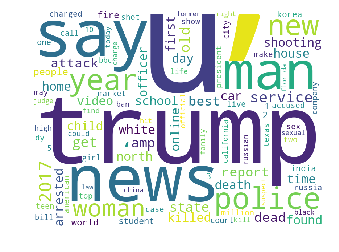

In [209]:
wordcloud = WordCloud(width=800, height=600, relative_scaling = 1.0, background_color='white', max_words=100).generate_from_frequencies(wordfreqdist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [215]:
news_reddit['final_titles'] = news_reddit['lemmatized_titles'].apply(lambda x:  ' '.join(x))
news_reddit.head()

,title,score,num_comments,created_utc,lang,tokenized_titles,lemmatized_titles,y,final_titles
710863,The Latest: Obama places last-day call to Germ...,2,0,1484857231,en,"[latest, :, obama, places, last, -, day, call,...","[latest, obama, place, last, day, call, german...",1,latest obama place last day call germany merkel
743399,Why Niger and Mali cattle herders turned to jihad,12,2,1510482805,en,"[niger, mali, cattle, herders, turned, jihad]","[niger, mali, cattle, herder, turned, jihad]",1,niger mali cattle herder turned jihad
351253,German minister: Trump actions on Iran deal co...,1,0,1508022592,en,"[german, minister, :, trump, actions, iran, de...","[german, minister, trump, action, iran, deal, ...",0,german minister trump action iran deal could m...
729819,The Dutch king has been moonlighting as a KLM ...,5,0,1495074345,en,"[dutch, king, moonlighting, klm, pilot, years]","[dutch, king, moonlighting, klm, pilot, year]",1,dutch king moonlighting klm pilot year
778358,Le Pen party charged over EU ake jobs',167,21,1513105919,en,"[le, pen, party, charged, eu, ake, jobs, ']","[le, pen, party, charged, eu, ake, job]",1,le pen party charged eu ake job


In [216]:
## Przygotowanie zmiennej obajsnianej

In [217]:
news_reddit['y'] = np.where(news_reddit['score']<=1, 0, 1)
news_reddit = news_reddit.sample(frac=1.0)
news_reddit.head()

,title,score,num_comments,created_utc,lang,tokenized_titles,lemmatized_titles,y,final_titles
742954,Treasury Secretary Steve Mnuchin just put Harr...,11,54,1504226094,en,"[treasury, secretary, steve, mnuchin, put, har...","[treasury, secretary, steve, mnuchin, put, har...",1,treasury secretary steve mnuchin put harriet t...
766577,Police: No signs of criminality in New York ju...,317,109,1492089402,en,"[police, :, signs, criminality, new, york, jud...","[police, sign, criminality, new, york, judge, ...",1,police sign criminality new york judge death
141813,Personal I-T base must be up before corporate ...,1,0,1486200985,en,"[personal, -, base, must, corporate, tax, cut,...","[personal, base, must, corporate, tax, cut, ha...",0,personal base must corporate tax cut hasmukh a...
716896,Florida elementary school teacher caught with ...,2,0,1506100224,en,"[florida, elementary, school, teacher, caught,...","[florida, elementary, school, teacher, caught,...",1,florida elementary school teacher caught meth
726004,WikiLeaks operative Claims Emails Given by Dem...,3,7,1484001005,en,"[wikileaks, operative, claims, emails, given, ...","[wikileaks, operative, claim, email, given, de...",1,wikileaks operative claim email given dem insi...


## Bag Of Words - BoW

Bag of words is a text representation and a way of extracting features. In BoW a document is understood as a bag containing words without taking care of order of words or sentences. 
This kind of representation of text involves a vocabulary and a measure of presence of words.

In [218]:
bow_transformer = CountVectorizer()
bow_transformer.fit(news_reddit['final_titles'])


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [219]:
example_bow = bow_transformer.transform([news_reddit["final_titles"][0]])

In [220]:
print(example_bow)

  (0, 12715)	1
  (0, 20157)	1
  (0, 30512)	1
  (0, 39718)	1
  (0, 41356)	1
  (0, 51956)	1
  (0, 52456)	1
  (0, 52788)	1


In [221]:
titles_bow = bow_transformer.transform(news_reddit["final_titles"])

In [222]:
print ('Shape of Sparse Matrix: ', titles_bow.shape)
print ('Amount of Non-Zero occurences: ', titles_bow.nnz)

Shape of Sparse Matrix:  (142614, 59952)
Amount of Non-Zero occurences:  1125169


### TFIDF - Term Frequency-Inverse Document Frequency

Statistical measure, which is used to check how important the word is in to the document in whole corpus. The importance increases proportionally to the number of occurences of word in document, but is offset by the frequency of the word in the corpus.


Tfidf = TF x IDF

* TF(x) = (number of occurences of word in document) / (number of words in document)
* IDF(x) = ln(number fo documents/number of documents containing this word)



In [223]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(titles_bow)

In [224]:
print(tfidf_transformer.transform(example_bow))

  (0, 52788)	0.28090066231185584
  (0, 52456)	0.28083038550791634
  (0, 51956)	0.5346794990646011
  (0, 41356)	0.38985062110457114
  (0, 39718)	0.32933749083842456
  (0, 30512)	0.317240293269996
  (0, 20157)	0.33083894708333667
  (0, 12715)	0.2929239552164514


In [225]:
titles_tfidf = tfidf_transformer.transform(titles_bow)

## Models

### Model on bow - count

In [226]:
X_train_bow, X_test_bow, Y_train_bow, Y_test_bow = train_test_split(titles_bow, news_reddit['y'], test_size=0.3, random_state=1)

In [227]:
clf = MultinomialNB()
clf.fit(X_train_bow, Y_train_bow)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [228]:
clf.score(X_test_bow,Y_test_bow)

0.7597989949748744

In [229]:
Y_pred = (clf.predict(X_test_bow))
confusion_matrix(Y_test_bow, Y_pred_bow)

array([[ 8881, 12336],
       [ 8906, 12662]], dtype=int64)

### Model on TF-IDF

In [230]:
X_train_tfidf, X_test_tfidf, Y_train_tfidf, Y_test_tfidf = train_test_split(titles_tfidf, news_reddit['y'], test_size=0.3, random_state=1)

In [231]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, Y_train_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [232]:
clf.score(X_test_tfidf,Y_test_tfidf)

0.7587238518172257

In [233]:
Y_pred_tfidf = (clf.predict(X_test_tfidf))
confusion_matrix(Y_test_tfidf, Y_pred_tfidf)

array([[14128,  7089],
       [ 3234, 18334]], dtype=int64)